In [95]:
import jieba
import collections
import re
from math import *
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import matplotlib.font_manager as fm

jieba.set_dictionary('./dict.txt')

In [96]:
def preprocessing(articles):
    dataset = list()
    for line in articles: # 先取少數篇
        sentences = line[:-1].split('t') # print(sentences)
        for i in range(len(sentences)):
            sentences[i] = re.sub(r'\W+', "", sentences[i])
        # print(sentences[0])
        words = list(jieba.cut(sentences[0], cut_all=False))
        dataset.append(words)
    return list(dataset)

In [97]:
def word_tf_in_dataset(dataset):
    all_word_statistics = collections.Counter()
    for article in dataset:
        all_word_statistics += collections.Counter(article)
    # print(all_word_statistics)
    total = sum(all_word_statistics.values(), 0.0)
    all_word_tf = {key: round((val/total), 3) for key, val in sorted(all_word_statistics.items(), key=lambda x: x[1], reverse=True)}
    # print(all_word_tf)
    return all_word_tf

In [98]:
def tf(article): # t: 詞
    word_statistics = collections.Counter()
    word_statistics += collections.Counter(list(article))
    total = sum(word_statistics.values(), 0.0)
    word_tf = {key: round((val/total), 2) for key, val in sorted(word_statistics.items(), key=lambda x: x[1], reverse=True)}
    
    return word_tf

In [99]:
def idf(tf_per_article_table): # t: 詞
    word_appear_count = collections.Counter()
    for i in range(len(tf_per_article_table)):
        word_appear_count += collections.Counter({key: 1 for key in tf_per_article_table[i].keys()})
    
    idf_table = {word: round(log10(len(tf_per_article_table) / count), 3) for word, count in sorted(word_appear_count.items(), key=lambda x: x[1], reverse=False)}
    return idf_table

In [100]:
def tf_idf(tf_t_d, idf_t_D):
    table = dict()
    for t, tf in tf_t_d.items():
        if table.get(t) == None:
            table[t] = round((tf * idf_t_D[t]), 3)
        elif table.get(t) != None and round((tf * idf_t_D[t]), 3) > table[t]:
            table[t] = round((tf * idf_t_D[t]), 3)
    return {key: val for key, val in sorted(table.items(), key=lambda x: x[1], reverse=True)}

In [101]:
def rank_100(tf_idf_table):
    skip_flag = {key: False for key in tf_idf_table.keys()}
    rank_100 = {'a': 0.0}
    min_in_rank = ('a', 0.0)
    idx = 0
    while True:
        stop_flag = True
        for i in range(len(tf_idf_table)):
            if idx >= len(tf_idf_table[i].items()): # 第 i 篇文章已經沒人比
                continue # 換下一篇
            if skip_flag[i] != True: # 第 i 篇文章還有詞有競爭力, 不跳過
                word, weight = tuple(tf_idf_table[i].items())[idx] # 把 詞, 權重 用簡單的變數存
                if weight > min_in_rank[1]: # if 權重大於排行榜的最後一名(的權重)
                    rank_100[ word ] = weight # 加進新人
                    if len(rank_100) > 100: # 若排行榜超過 100 人 (還沒滿的話就沒事了)
                        rank_100.pop(min_in_rank[0]) # 踢掉最小
                        new_rank_list = sorted(rank_100.items(), key=lambda x: x[1], reverse=True) # 重排
                        min_in_rank = new_rank_list[-1] # 找出新的最後一名
                        rank_100 = {key: val for key, val in new_rank_list} # 更新 rank_100
                    
                    stop_flag = False
                else:
                    skip_flag[i] = True
        if stop_flag == True:
            break
        idx += 1
    
    return list(rank_100.items())

In [102]:
def draw(rank_100, filename, row_labels, col_labels):
    x = [item[0] for item in rank_100]
    y = [item[1] for item in rank_100]
    fontPath = r'C:\Users\ycotj\Desktop\大學\NLP\NotoSansCJKtc-hinted\NotoSansCJKtc-Light.otf'
    font = fm.FontProperties(fname=fontPath, size=10)
    
    fig = plt.figure(figsize=(30, 30))
    plt.bar(x, y)
    plt.xticks(range(len(x)), x, fontproperties=font)
    plt.title(filename)
    plt.xlabel(row_labels)
    plt.ylabel(col_labels)
    
    plt.savefig(".\\" + filename + ".png")
    return None

Building prefix dict from C:\Users\ycotj\Desktop\大學\NLP\dict.txt ...
Loading model from cache C:\Users\ycotj\AppData\Local\Temp\jieba.u2c41ba3fe2f0526b22ed3f998e537284.cache
Loading model cost 0.409 seconds.
Prefix dict has been built successfully.


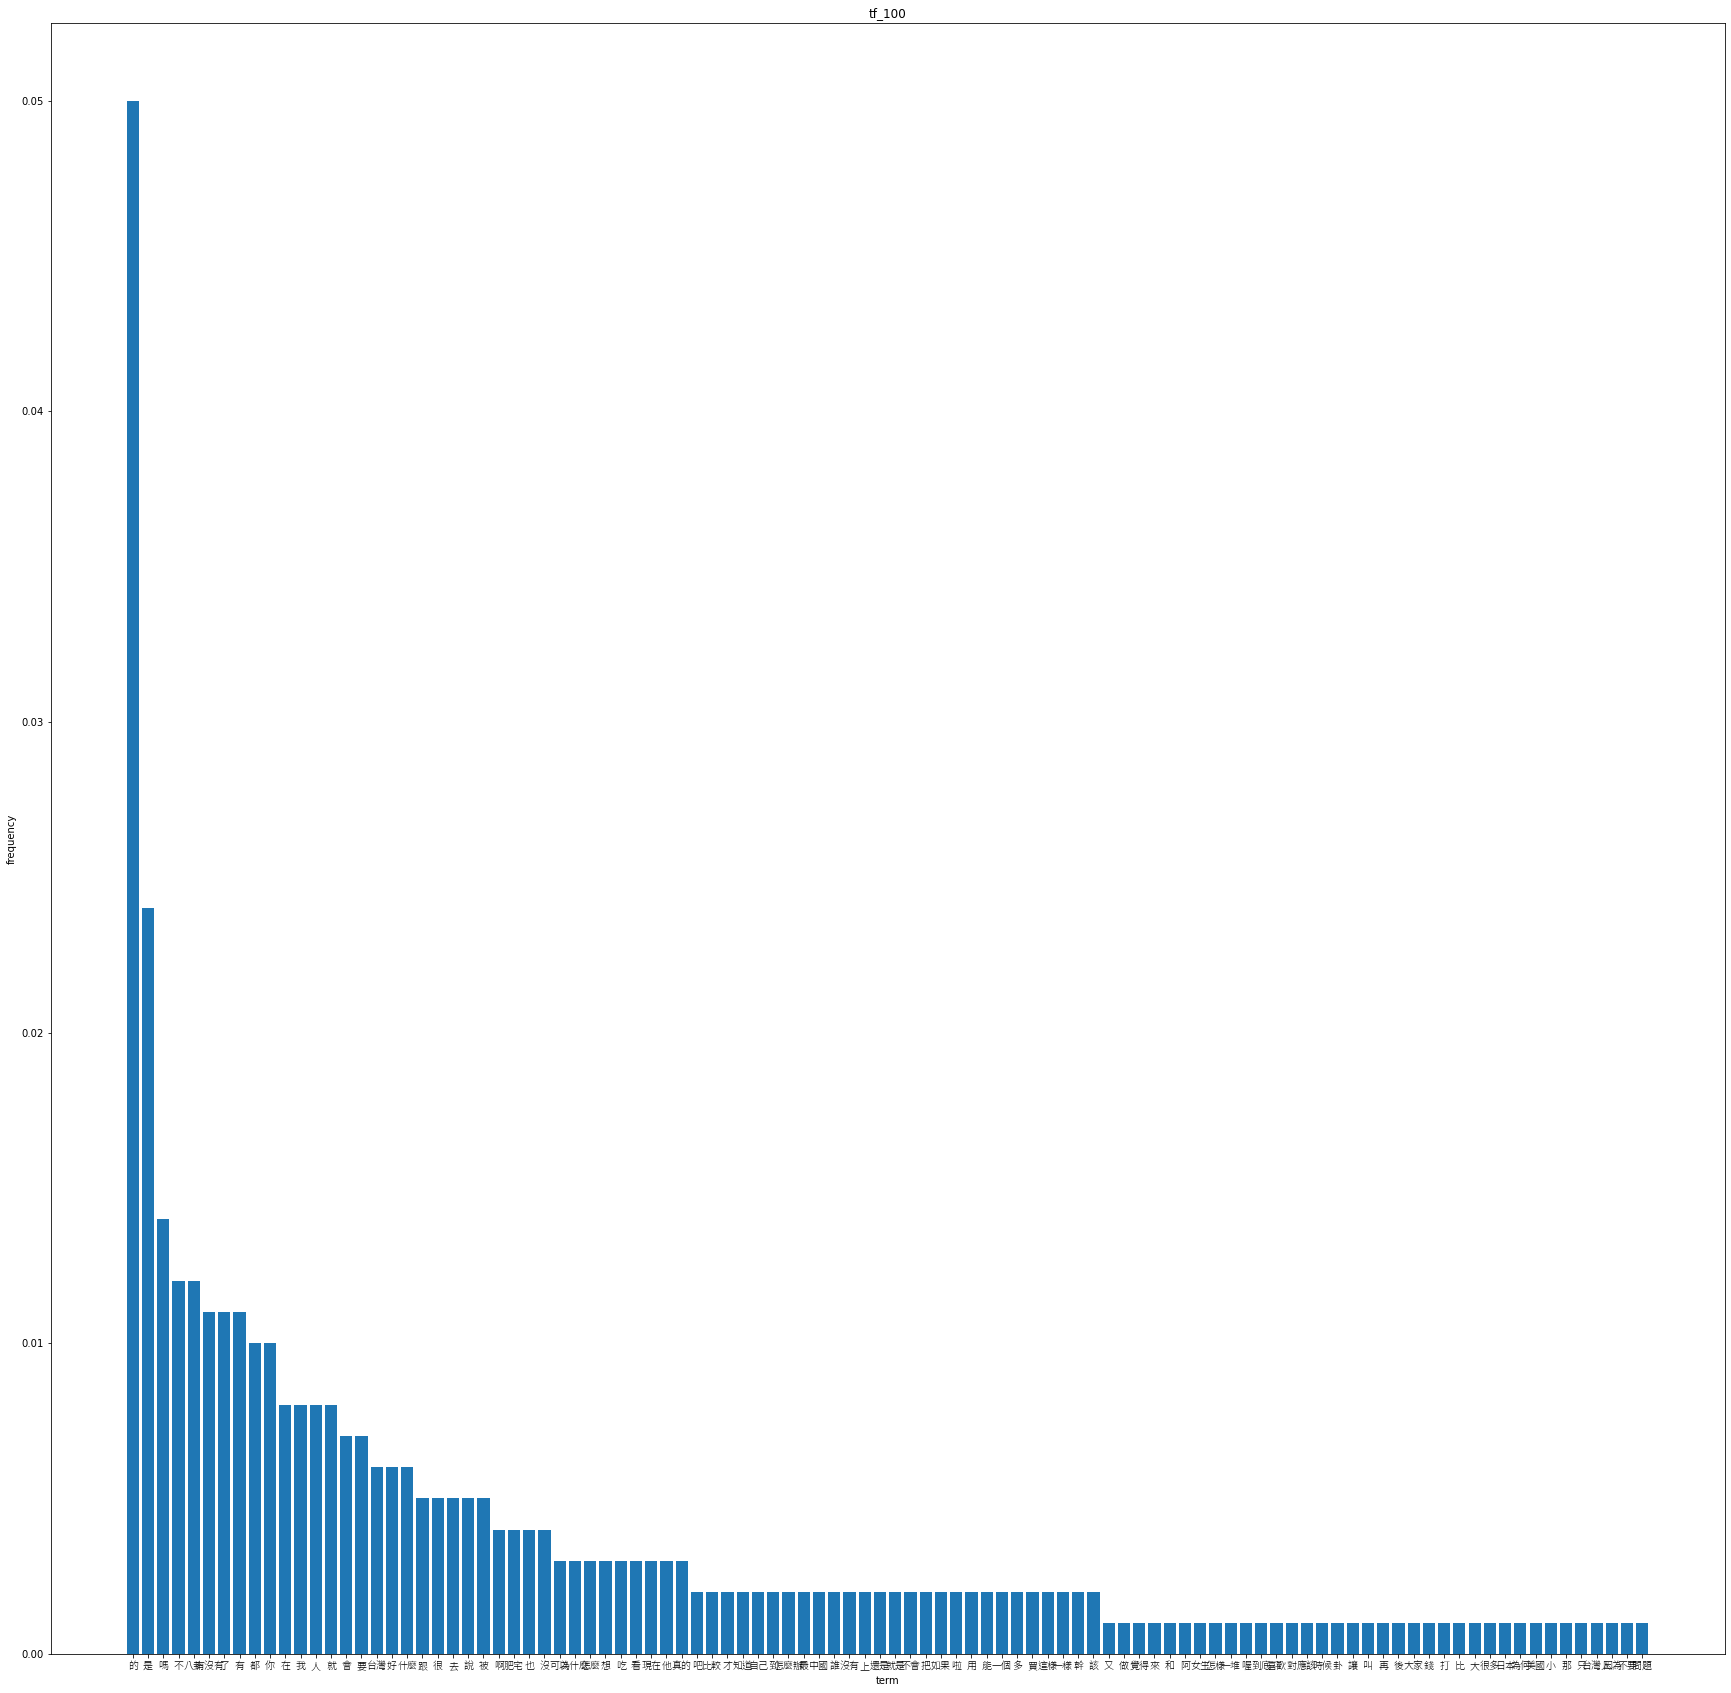

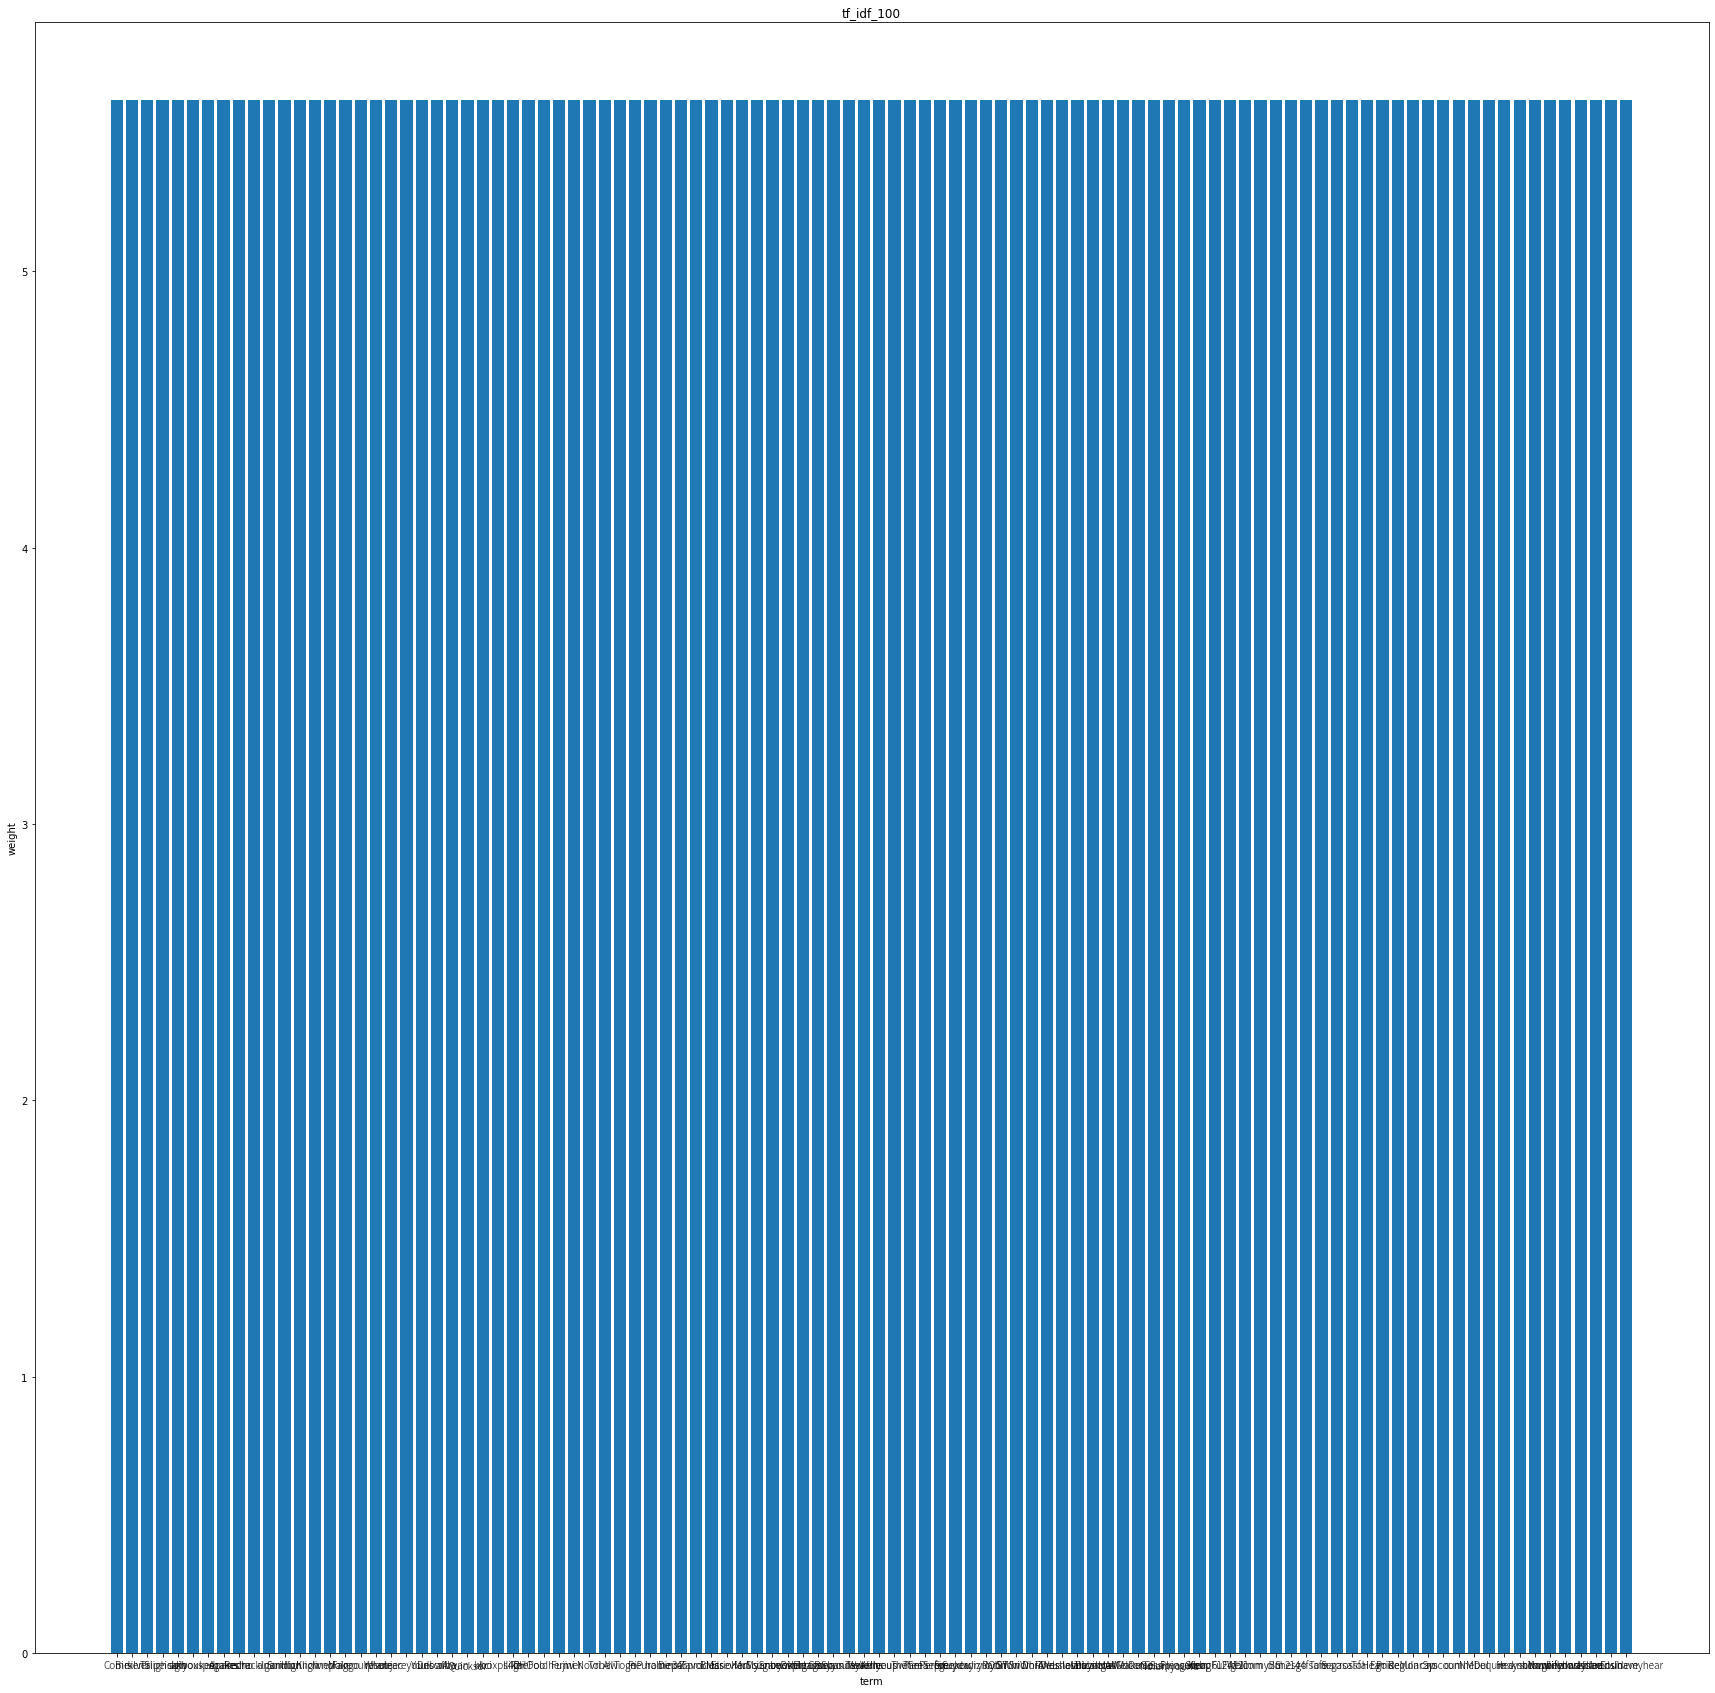

In [103]:
def main():
    file = open("./hw1-dataset.txt", mode='r', encoding='utf-8')
    articles = file.readlines()
    # print(articles[:3])
    # python 陣列: list
    dataset = preprocessing(articles)
    # print(dataset)
    ### 統計高頻
    tf_whole_dataset_table = word_tf_in_dataset(dataset)
    tf_100 = list(tf_whole_dataset_table.items())[:100]
    # print(tf_100)
    
    ### 建每篇文章的 tf table
    tf_per_article_table = dict()
    for article_no in range(len(dataset)):
        tf_per_article_table[article_no] = tf(dataset[article_no])
        # print(tf_per_article_table[article_no])
    # print(tf_per_article_table)
    # print(pd.DataFrame(list(list(tf_per_article_table.values())[0].items()), columns=['word', 'tf']))
    
    ### 建 idf table
    idf_table = idf(tf_per_article_table)
    # print(idf_table)
    
    ### 統計 tf-idf 高
    tf_idf_table = dict()
    for article_no in range(len(dataset)):
        tf_idf_table[article_no] = tf_idf(tf_per_article_table[article_no], idf_table)
    # print(tf_idf_table)
    tf_idf_100 = rank_100(tf_idf_table)
    # print(tf_idf_100)
    
    ### 畫圖
    draw(tf_100, "tf_100", "term", "frequency")
    draw(tf_idf_100, "tf_idf_100", "term", "weight")
    
    file.close()
main()

        
    